In [5]:
import sys
sys.path.append("../")

import utils
from crbm import CRBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

In [3]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/pig_trained_crbms/ge2/"
rounds = ["b3", "n1", "np1", "np2", "np3"]
c1_rounds = [x+"_c1" for x in rounds]
c2_rounds = [x+"_c2" for x in rounds]

In [6]:
# Methods for generating plots etc.
def assign(x):
    if x < 2:
        return "Low"
    elif x < 10:
        return "Mid"
    else:
        return "High"


# Stores all data in a dictionary ("data")
data_c1 = am.fetch_data(c1_rounds, dir="../../pig_tissue/gaps_end_2_clusters/", counts=True, assignment_function=assign)

Process Time 0.6212403774261475
Process Time 1.0022964477539062
Process Time 1.230752944946289
Process Time 0.6266195774078369
Process Time 1.133131980895996


In [8]:
# generate weights in each respective model
for rid, round in enumerate(c1_rounds):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = CRBM.load_from_checkpoint(checkp)
    utils.all_weights(tmp, name=version_dir +round)

../utils.py:809: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (95040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [9]:
# Generate Sequence Logo for Each round
for r in c1_rounds:
    am.seq_logo(data_c1[data_c1["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/")
    am.seq_logo(data_c1[data_c1["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/")

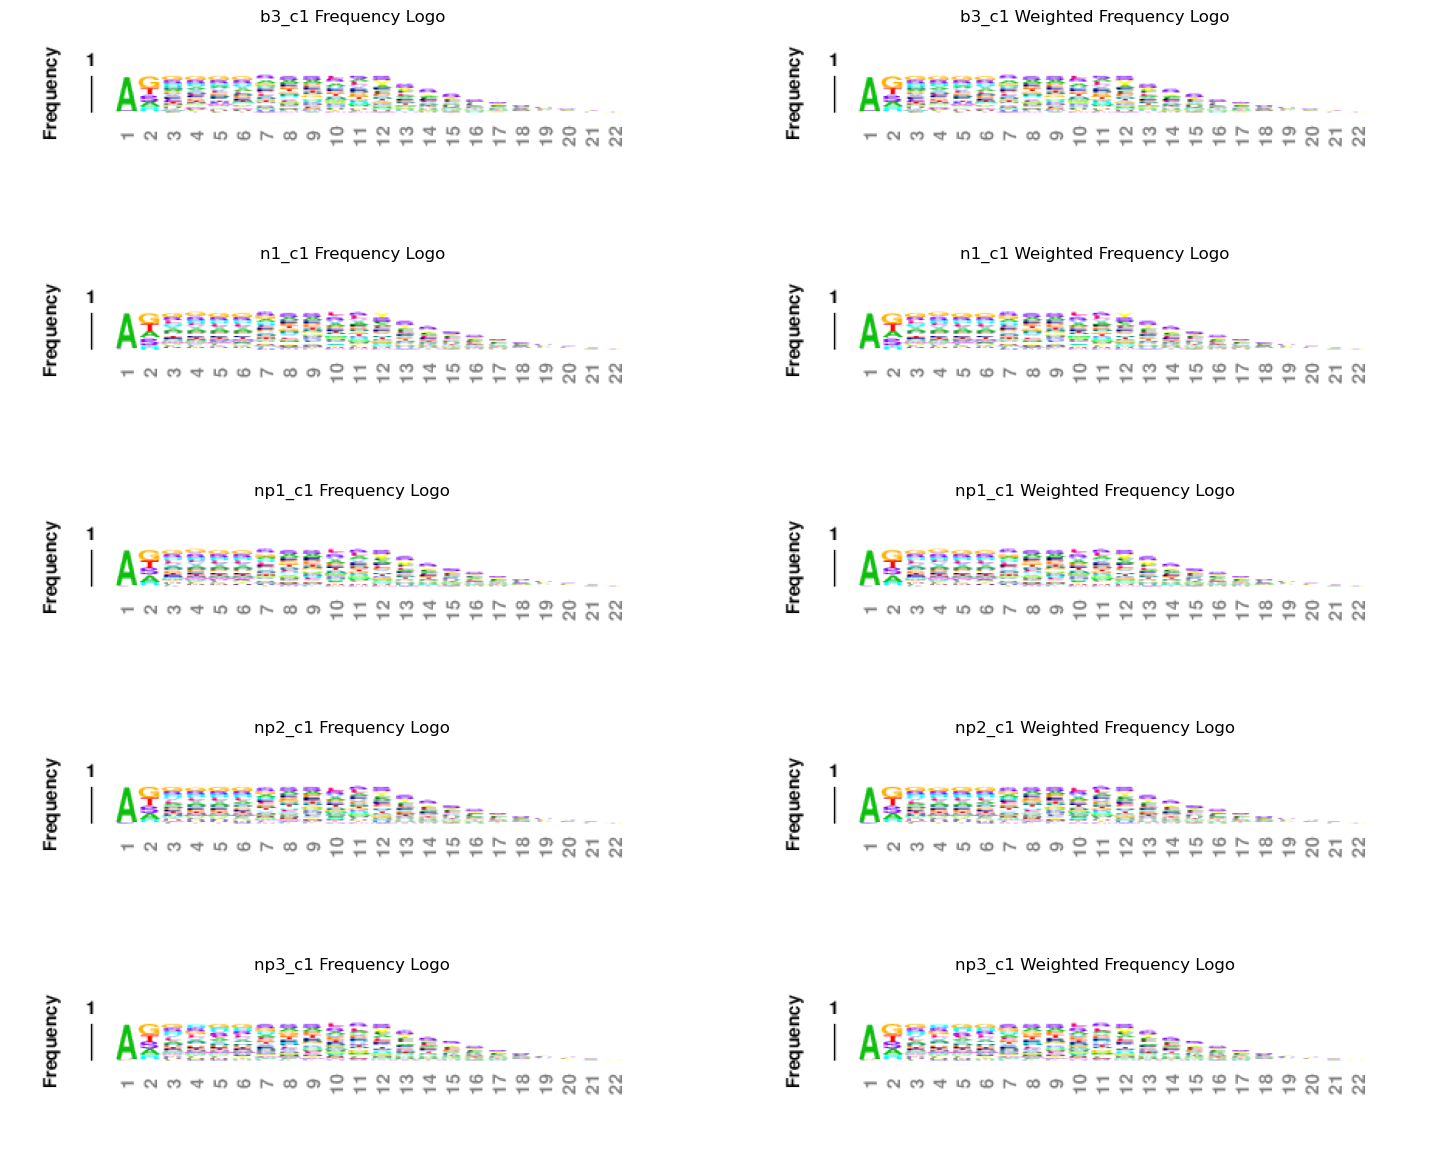

In [12]:
# Seq Logo showing Frequency of Each Amino Acid at each position

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)
seqdir = "./generated/"
plt.tight_layout()
for rid, r in enumerate(c1_rounds):
    img1 = mpimg.imread(f"{seqdir}{r}_seqlogo.freq.png")
    img2 = mpimg.imread(f"{seqdir}{r}_w_seqlogo.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

# plt.axis('off')
plt.show()

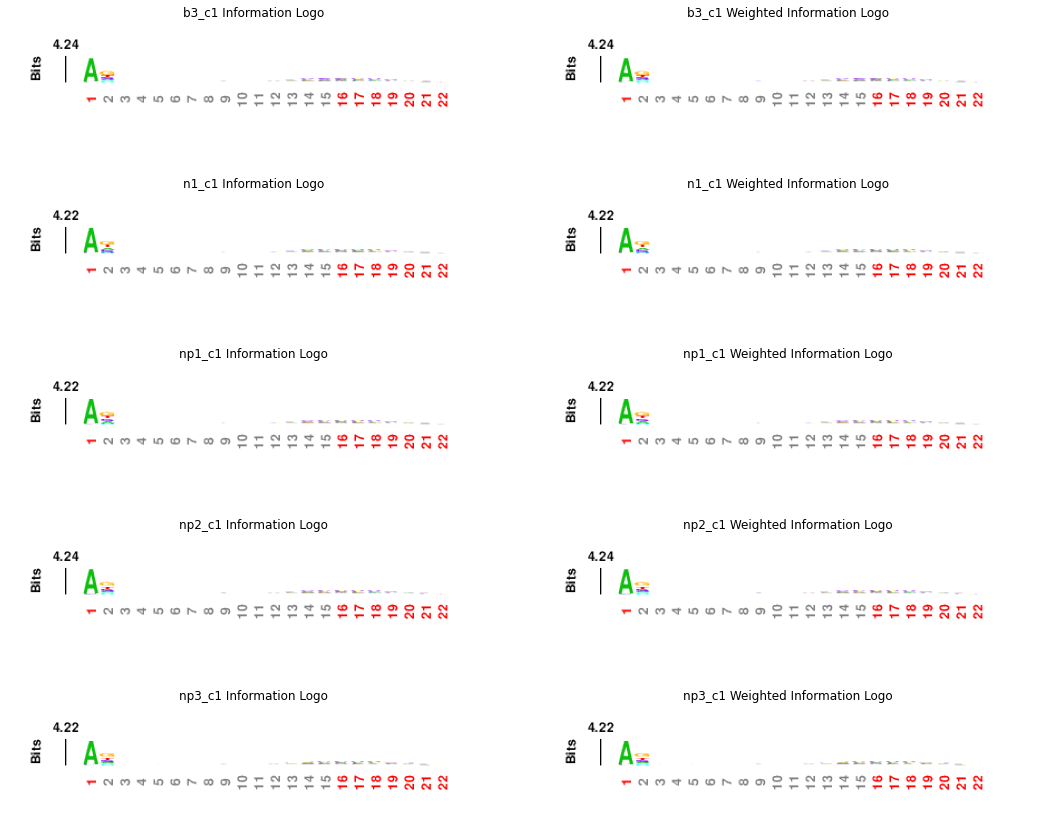

In [20]:
# Seq Logo showing Information of Each Amino Acid at each position

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(15, 12)
seqdir = "./generated/"
plt.tight_layout()
for rid, r in enumerate(c1_rounds):
    img1 = mpimg.imread(f"{seqdir}{r}_seqlogo.info.png")
    img2 = mpimg.imread(f"{seqdir}{r}_w_seqlogo.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Information Logo")
    axs[rid][1].set_title(f"{r} Weighted Information Logo")

# plt.axis('off')
plt.show()

In [7]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    # sns.histplot(data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

# count_dist(all_data, "Unique Sequence Count Distribution")

count_dist(data_c1, "Unique Sequence Count Distribution C1")
# Low count == 1, Med count < 10, High count >= 10

ValueError: cannot set using a list-like indexer with a different length than the value

In [13]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("np3_c1", rbmdir=mdir)
np3_crbm = CRBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(c1_rounds, np3_crbm, data_c1, "np3_crbm_v0_all")

In [14]:
np3_likelihoods = am.get_likelihoods("./generated/np3_crbm_v0_all.json")

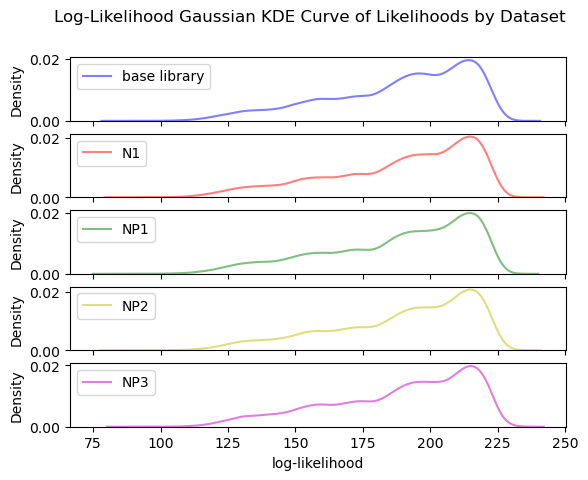

In [15]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(np3_likelihoods["likelihoods"], c1_rounds, ["base library", "N1", "NP1", "NP2", "NP3"], xlim=None, cdf=False)

In [16]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("b3_c1", rbmdir=mdir)
b3_crbm = CRBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(c1_rounds, b3_crbm, data_c1, "b3_crbm_v0_all")

In [17]:
b3_likelihoods = am.get_likelihoods("./generated/b3_crbm_v0_all.json")

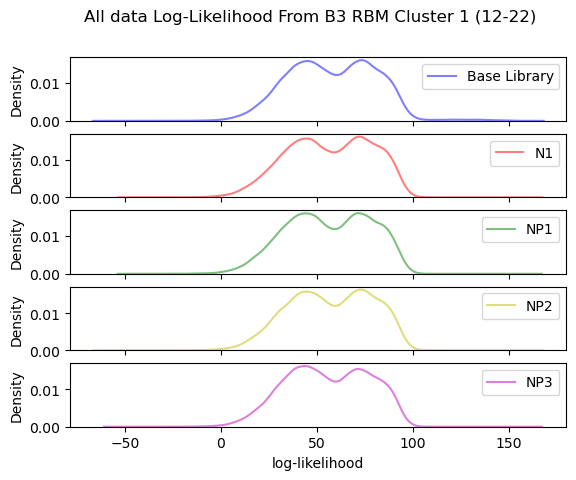

In [18]:
# assign likelihoods in new pd dataframe
b3_title = "All data Log-Likelihood From B3 RBM Cluster 1 (12-22)"
# Plot Likelihood Distributions
am.plot_likelihoods(b3_likelihoods["likelihoods"], c1_rounds, ["Base Library", "N1", "NP1", "NP2", "NP3"], title=b3_title, cdf=False, xlim=None)

In [25]:
# find in common sequences
common = data["b3_c1"].merge(data["np3_c1"], on=['sequence'])
print("Common Sequences b3 & np3", common.shape[0])
common = data["b3_c1"].merge(data["np2_c1"], on=['sequence'])
print("Common Sequences b3 & np2", common.shape[0])
common = data["b3_c1"].merge(data["np1_c1"], on=['sequence'])
print("Common Sequences b3 & np1", common.shape[0])
common = data["b3_c1"].merge(data["n1_c1"], on=['sequence'])
print("Common Sequences b3 & n1", common.shape[0])

# All together
common = data["b3_c1"].merge(data["np3_c1"], on=['sequence'])
common1 = common.merge(data["np2_c1"])
common2 = common1.merge(data["np1_c1"])
common3 = common2.merge(data["n1_c1"])
common4 = data["np1_c1"].merge(data["np2_c1"].merge(data["np3_c1"]))
common5 = common4.merge(data["n1_c1"])
print("Common Sequences b3 & np3", common.shape[0])
print("Common Sequences b3 & np3 & np2", common1.shape[0])
print("Common Sequences b3 & np3 & np2 & np1", common2.shape[0])
print("Common Sequences b3 & np3 & np2 & np1 & n1", common3.shape[0])
print("Common Sequences np3 & np2 & np1 & n1", common5.shape[0])
print("Common Sequences np3 & np2 & np1", common4.shape[0])

Common Sequences b3 & np3 22794
Common Sequences b3 & np2 15037
Common Sequences b3 & np1 26164
Common Sequences b3 & n1 22417
Common Sequences b3 & np3 22794
Common Sequences b3 & np3 & np2 9895
Common Sequences b3 & np3 & np2 & np1 7376
Common Sequences b3 & np3 & np2 & np1 & n1 4443
Common Sequences np3 & np2 & np1 & n1 9894
Common Sequences np3 & np2 & np1 21806


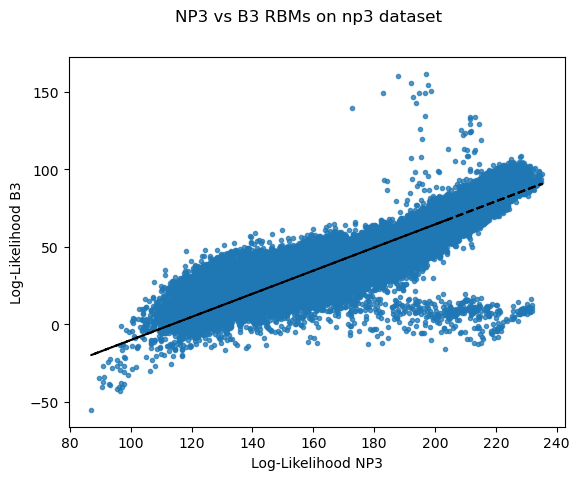

In [19]:
am.compare_likelihood_correlation(np3_likelihoods["likelihoods"]["np3_c1"], b3_likelihoods["likelihoods"]["np3_c1"], "NP3 vs B3 RBMs on np3 dataset", ["NP3", "B3"])

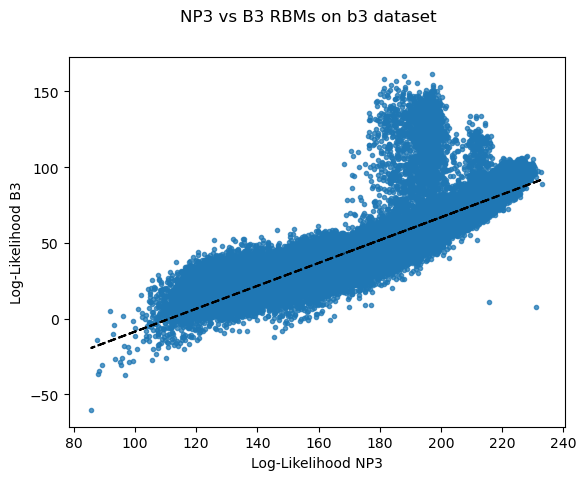

In [20]:
am.compare_likelihood_correlation(np3_likelihoods["likelihoods"]["b3_c1"], b3_likelihoods["likelihoods"]["b3_c1"], "NP3 vs B3 RBMs on b3 dataset", ["NP3", "B3"])

In [22]:
import torch

def dataframe_to_input(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten


# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
     # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)

def prepare_input_vector(crbm, dataframe):
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[crbm.molecule]
        data_tensor, weights = dataframe_to_input(dataframe, base_to_id, crbm.v_num, crbm.q, weights=True)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()

In [23]:
from sklearn.preprocessing import StandardScaler
input = prepare_input_vector(np3_crbm, data_c1[data_c1["round"] == "np3_c1"])
scaler = StandardScaler()
input_processed = scaler.fit_transform(input)

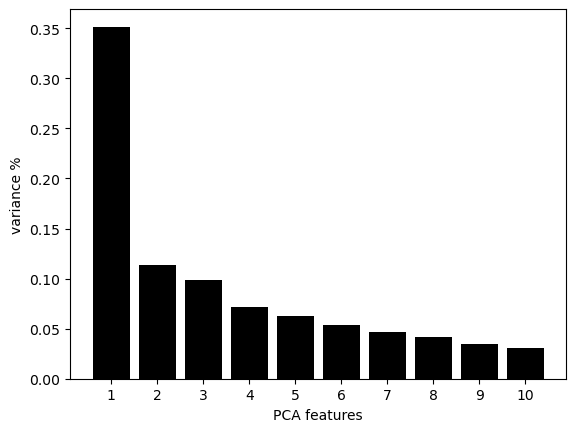

In [24]:
import clustering_methods as cm
cm.pca_component_check(input_processed, components=10)

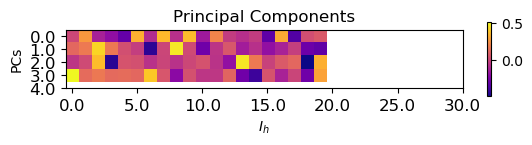

In [25]:
# We will do the first 4 components only, Drop in variance at feature 5
from sklearn.decomposition import PCA
X = input_processed
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X)
PCA_components_pd = pd.DataFrame(principal_components)
components = pca.components_
cm.view_components(components)

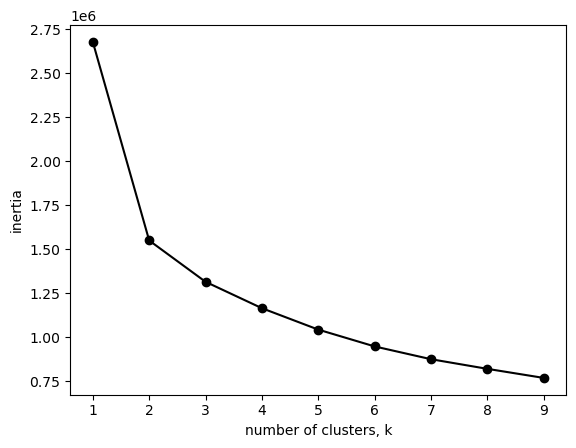

In [26]:
# KMeans on Transformed Sequences

from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd.iloc[:,:4])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [27]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([data_c1[data_c1["round"] == "np3_c1"].reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'1', 1:'2', 2:"3", 3:'4', 4:'5', 5:"6", 6:"7", 7:"8"})

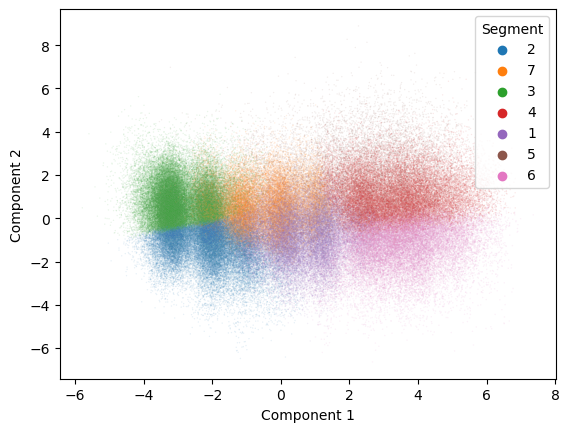

In [28]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

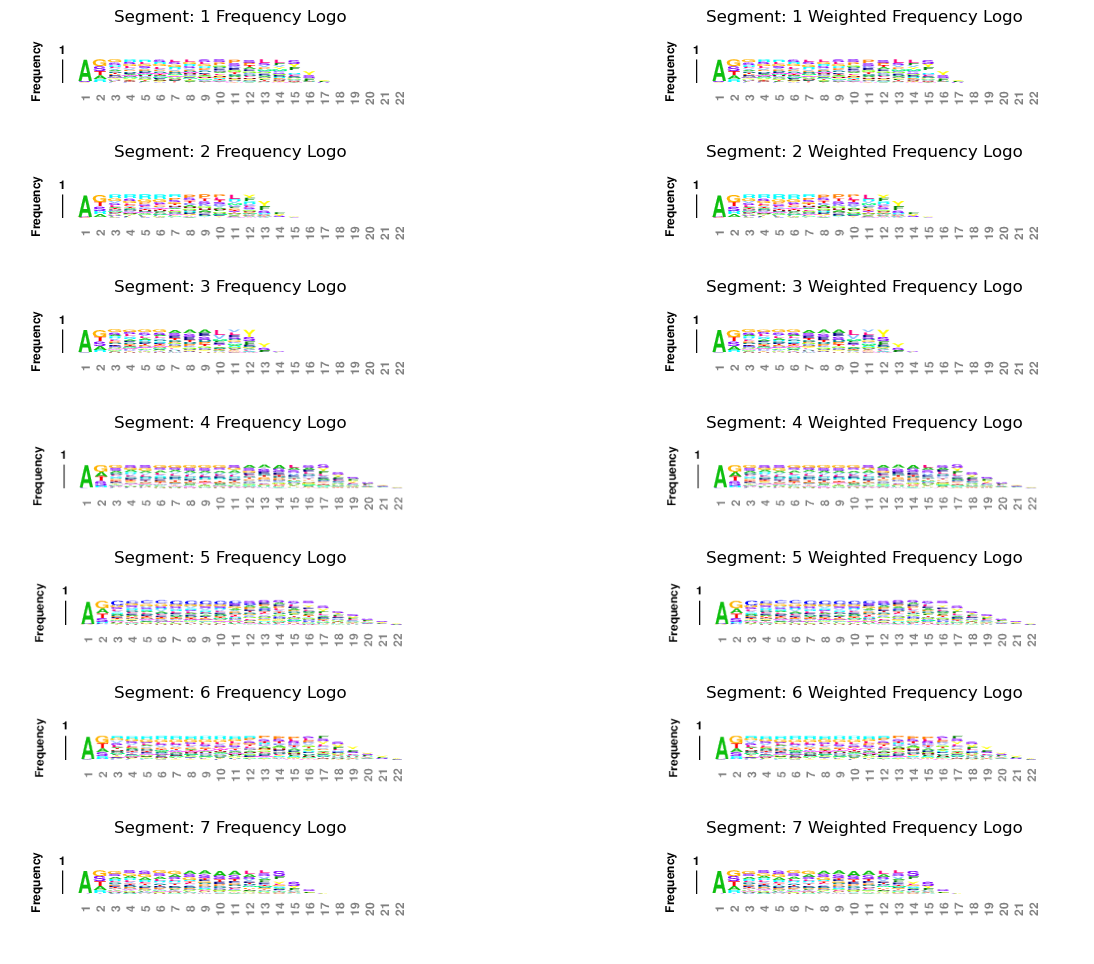

In [29]:
segments = ["1", "2", "3", "4", "5", "6", "7"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"pca_pig_ge2_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"pca_pig_ge2_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

In [30]:
segments = ["1", "2", "3", "4", "5", "6", "7"]
# Plot Likelihood Curves of individual segments
# am.supported_colors = ["b", "r", "g", "y", "m", "c", "k", "DarkKhaki", "DarkOrchid"]
df_pca_kmeans["likelihood"] = np3_likelihoods["likelihoods"]["np3_c1"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods

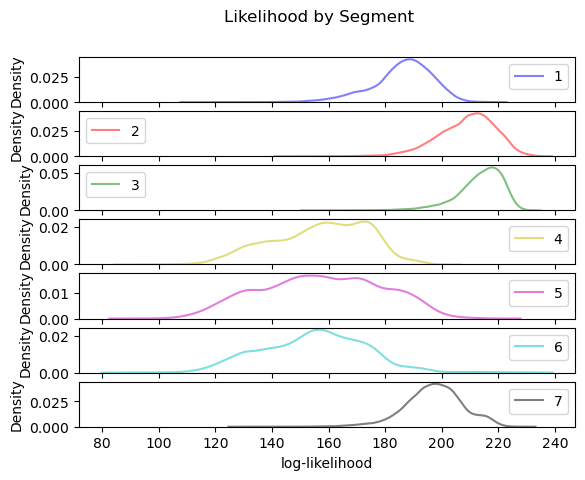

In [31]:
am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

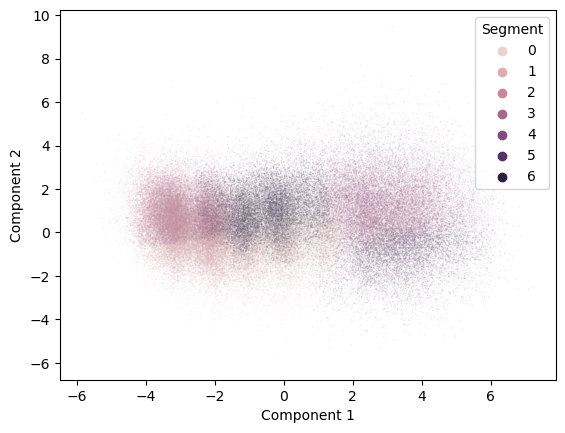

In [32]:
# NOW LETS CHECK LIKELIHOOD CURVES OF BASE LIBRARY separated by clusters
# prep input vector
input_b3 = prepare_input_vector(np3_crbm, data_c1[data_c1["round"] == "b3_c1"])
# Scale input vectors
input_processed = scaler.transform(input_b3)
# Calculate Components from previous fit on np3 data
b3_components = pca.transform(input_processed)
# Get per sequence cluster assignment by predicting the kmean cluster from the new PCA componenets
b3_cluster = kmeans_pca.predict(b3_components)

# Let's see how it clusters first
df_b3_segment = pd.DataFrame({"Segment": b3_cluster})
df_b3_components = pd.concat([df_b3_segment, pd.DataFrame(b3_components)], axis=1)
df_b3_components.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]

sns.scatterplot(data=df_b3_components, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

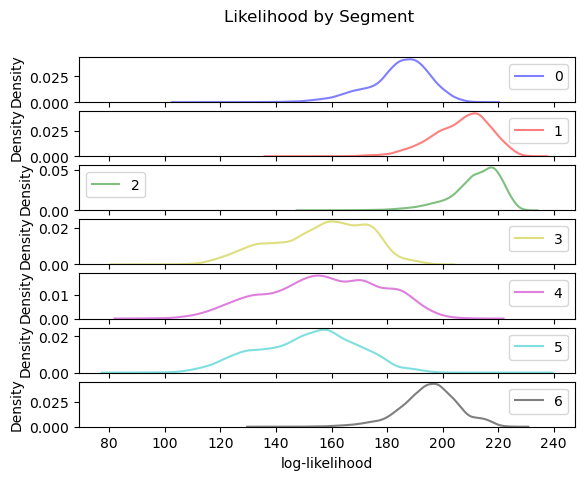

In [33]:
segments = [x for x in range(7)]
# Plot Likelihood Curves of individual segments
# am.supported_colors = ["b", "r", "g", "y", "m", "c", "k", "DarkKhaki", "DarkOrchid"]
df_b3_components["likelihood"] = np3_likelihoods["likelihoods"]["b3_c1"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_b3_components[df_b3_components["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods

am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

## Weighted RBMS

In [18]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("b3_c1_w", rbmdir=mdir)
b3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(c1_rounds, b3_rbm_w, data_c1, "b3_c1_w_all")

# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("np3_c1_w", rbmdir=mdir)
np3_rbm_w = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(c1_rounds, np3_rbm_w, data_c1, "np3_c1_w_all")

In [20]:
b3_w_likelihoods = am.get_likelihoods("./generated/b3_c1_w_all.json")
np3_w_likelihoods = am.get_likelihoods("./generated/np3_c1_w_all.json")

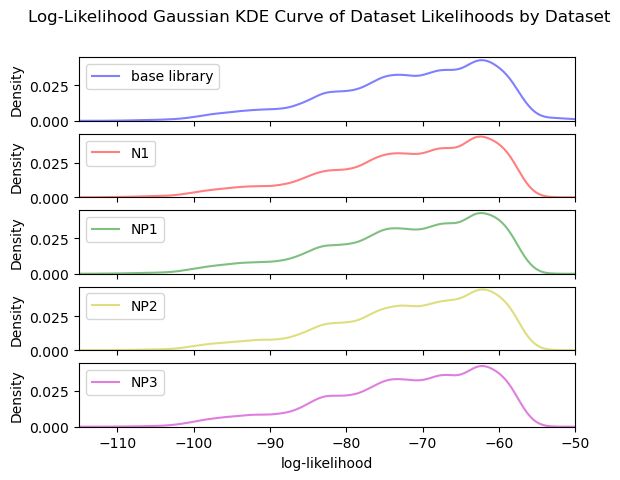

In [21]:
# Plot Likelihood Distributions
am.plot_likelihoods(b3_w_likelihoods["likelihoods"], c1_rounds, ["base library", "N1", "NP1", "NP2", "NP3"], xlim=(-115, -50), cdf=False)

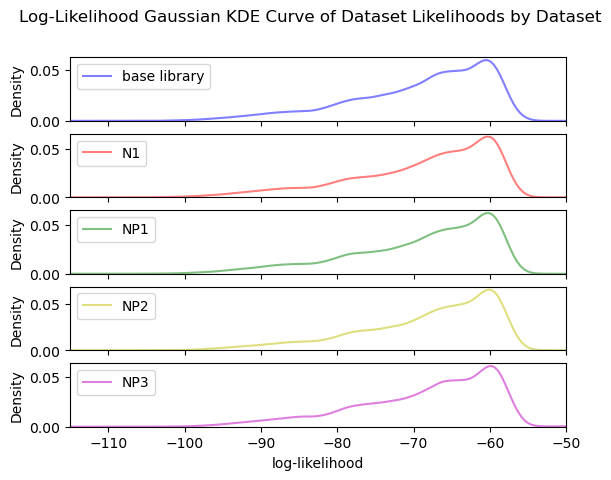

In [22]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(np3_w_likelihoods["likelihoods"], c1_rounds, ["base library", "N1", "NP1", "NP2", "NP3"], xlim=(-115, -50), cdf=False)

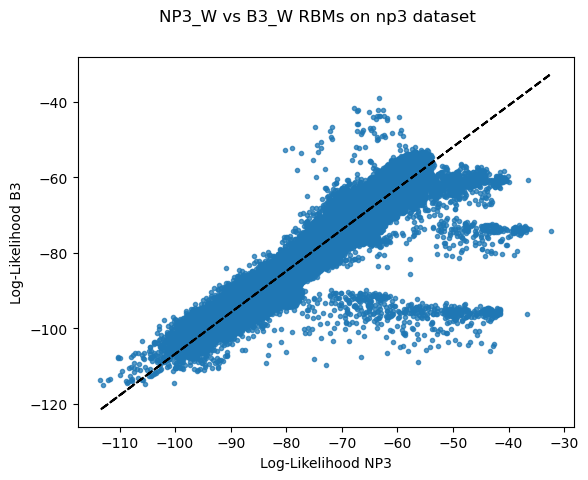

In [23]:
am.compare_likelihood_correlation(np3_w_likelihoods["likelihoods"]["np3_c1"], b3_w_likelihoods["likelihoods"]["np3_c1"], "NP3_W vs B3_W RBMs on np3 dataset", ["NP3", "B3"])

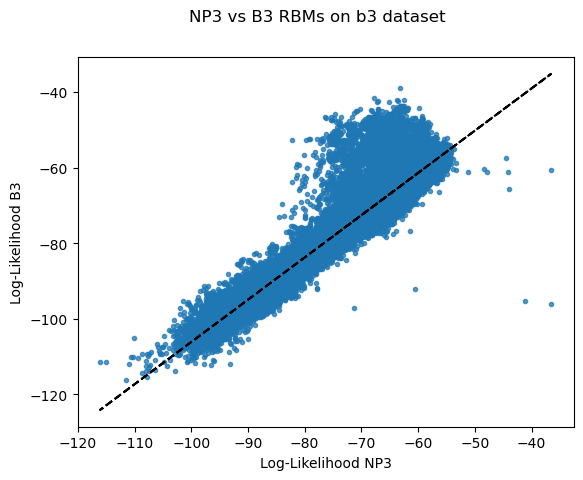

In [24]:
am.compare_likelihood_correlation(np3_w_likelihoods["likelihoods"]["b3_c1"], b3_w_likelihoods["likelihoods"]["b3_c1"], "NP3 vs B3 RBMs on b3 dataset", ["NP3", "B3"])